In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install ratelimit
!pip install requests_cache
!pip install munch
# rate limiting is important to avoid accidental service abuse of the OpenFDA API provider
from ratelimit import limits, sleep_and_retry

# cache API calls in a sqllite file to reduce the number of requests to openfda server
import requests_cache
requests_cache.install_cache('openfda_cache')

OPENFDA_API = "https://api.fda.gov/device/event.json" #?api_key=ArFziGcwRiXI9lsOaA7B5DZabrybYKLKxJ8a2gAh"

@sleep_and_retry
@limits(calls=40, period=60)
def call_api(params):
    """
    OpenFDA API call. Respects rate limit. Overrides default data limit
    Input: dictionary with API parameters {search: '...', count: '...'}
    Output: nested dictionary representation of the JSON results section

    OpenFDA API rate limits:
         With no API key: 40 requests per minute, per IP address. 1000 requests per day, per IP address.
         With an API key: 240 requests per minute, per key. 120000 requests per day, per key.
    """
    if not params:
        params = {}
    #params['api_key'] = 'QkdJ2P9kUOVrImPVFbyIoXywBbQ46rQiHoXtQs44'
    params['limit'] = params.get('limit', 1000)
    response = requests.get(OPENFDA_API, params=params)
    # print(response.url)

    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    return response.json()['results']


OPENFDA_METADATA_YAML = "https://open.fda.gov/fields/deviceevent.yaml"
# munch is a yaml parser with javascript-style object access
from munch import Munch

def api_meta():
    """
    YAML file with field description and other metadata retrieved from the OpenFDA website
    Parses YAML file and provides syntactic sugar for accessing nested dictionaries
    Example: .patient.properties.patientagegroup.possible_values.value
    Note: reserved words, such as count and items still have to be accessed via ['count'], ['items']
    """
    response = requests.get(OPENFDA_METADATA_YAML)
    if response.status_code != 200:
        raise Exception('Could not retrieve YAML file with drug event API fields')
    y = Munch.fromYAML(response.text)
    return y['properties']

In [2]:
api_meta().keys()

dict_keys(['adverse_event_flag', 'date_facility_aware', 'date_manufacturer_received', 'date_of_event', 'date_received', 'date_report', 'date_report_to_fda', 'date_report_to_manufacturer', 'device', 'device_date_of_manufacturer', 'distributor_address_1', 'distributor_address_2', 'distributor_city', 'distributor_name', 'distributor_state', 'distributor_zip_code', 'distributor_zip_code_ext', 'event_key', 'event_location', 'event_type', 'expiration_date_of_device', 'health_professional', 'initial_report_to_fda', 'manufacturer_address_1', 'manufacturer_address_2', 'manufacturer_city', 'manufacturer_contact_address_1', 'manufacturer_contact_address_2', 'manufacturer_contact_area_code', 'manufacturer_contact_city', 'manufacturer_contact_country', 'manufacturer_contact_exchange', 'manufacturer_contact_extension', 'manufacturer_contact_f_name', 'manufacturer_contact_l_name', 'manufacturer_contact_pcity', 'manufacturer_contact_pcountry', 'manufacturer_contact_phone_number', 'manufacturer_contact

In [3]:
api_meta().device['items']['properties']['openfda'].keys()

dict_keys(['properties', 'type'])

In [4]:
api_meta().number_patients_in_event.keys()

dict_keys(['description', 'format', 'is_exact', 'possible_values', 'type'])

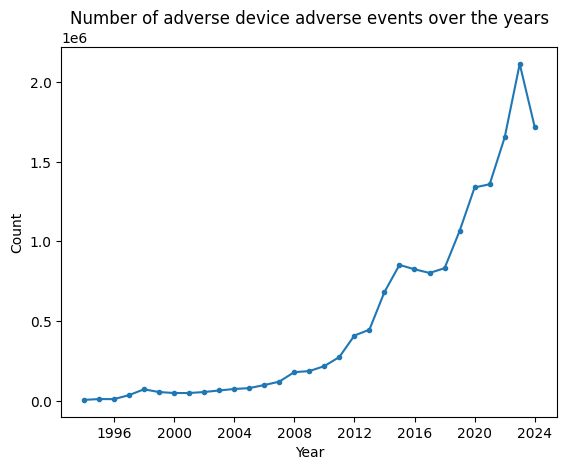

In [5]:
df = pd.DataFrame(
    call_api({
        #'api_key': "ArFziGcwRiXI9lsOaA7B5DZabrybYKLKxJ8a2gAh",
        'count':'date_report',
        'search': 'date_report:[19930101 TO 20231006]',
        })) # 'api_key': 'QkdJ2P9kUOVrImPVFbyIoXywBbQ46rQiHoXtQs44'
df.index = pd.to_datetime(df.time)
# tally reports by year
#df.drop('time', axis=1).resample("y").sum().plot(style='.-', figsize=(5, 3))
plt.plot(df.drop('time', axis=1).resample("y").sum(), marker='.')
total = df['count'].sum()
plt.title('Number of adverse device adverse events over the years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [6]:
api_meta().patient.keys() #.items()#.properties()#['patient_age'].keys()

dict_keys(['items', 'type'])

In [7]:
df_singleuse_flag_Y = pd.DataFrame(
    call_api({ "count":'single_use_flag.exact', "search":'adverse_event_flag:Y'}))
df_singleuse_flag_N = pd.DataFrame(
    call_api({ "count":'single_use_flag.exact', "search":'adverse_event_flag:N'}))
df_singleuse_flag_Y, df_singleuse_flag_N

(  term    count
 0    Y  4610165
 1        863509
 2    N   741018
 3    *   203951
 4    I    16311,
   term    count
 0    N  7243786
 1    Y  2828523
 2        874751
 3    *    89277
 4    I    19095)

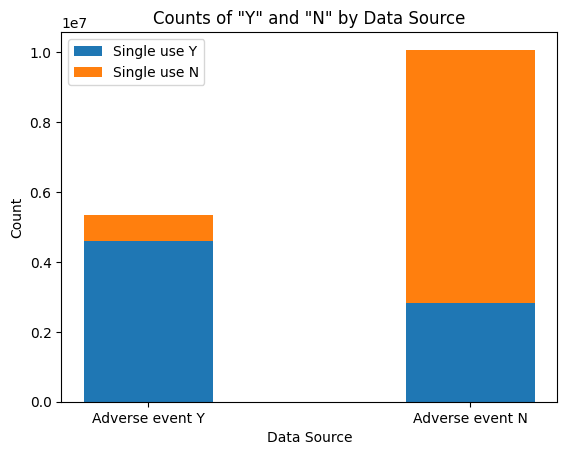

In [8]:
df1 = df_singleuse_flag_Y
df2 = df_singleuse_flag_N
# Create a figure and axis
fig, ax = plt.subplots()

# Extract 'Y' and 'N' counts from both DataFrames
count_y_data1 = df1[df1['term'] == 'Y']['count'].values[0]
count_n_data1 = df1[df1['term'] == 'N']['count'].values[0]
count_y_data2 = df2[df2['term'] == 'Y']['count'].values[0]
count_n_data2 = df2[df2['term'] == 'N']['count'].values[0]

# Define the x positions for the bars
x = [0.4, 1.6]  # Adjust the positions as needed

# Create stacked bar chart
bar_width = 0.4  # Adjust the width as needed
index = ['Adverse event Y', 'Adverse event N']

bar1 = plt.bar(index, [count_y_data1, count_y_data2], bar_width, label='Single use Y')
bar2 = plt.bar(index, [count_n_data1, count_n_data2], bar_width, label='Single use N', bottom=[count_y_data1, count_y_data2])

# Add labels and legend
plt.xlabel('Data Source')
plt.ylabel('Count')
plt.title('Counts of "Y" and "N" by Data Source')
plt.legend()

# Show the plot
plt.show()

In [9]:
df_adv_flag_Y = pd.DataFrame(
    call_api({ "count":'adverse_event_flag.exact', "search":'adverse_event_flag:Y'}))
df_adv_flag_N = pd.DataFrame(
    call_api({ "count":'adverse_event_flag.exact', "search":'adverse_event_flag:N'}))
df_adv_flag_Y, df_adv_flag_N

(  term    count
 0    Y  6434954,
   term     count
 0    N  11055432)

In [10]:
import re
df_male = pd.DataFrame(
    call_api({ "count":'patient.patient_age.exact', "search":'patient.patient_sex:Male'}))
#df_male.index = pd.to_datetime(df_male.time)
df_female = pd.DataFrame(
    call_api({ 'count':"patient.patient_age.exact",
        "search":"patient.patient_sex:Female"}))
df_male = df_male[df_male['term'].str.contains('YR')]
df_female = df_female[df_female['term'].str.contains('YR')]

df_male['term'] = [x[:2] for x in df_male['term'].values if 'YR' in x]
df_female['term'] = [x[:2] for x in df_female['term'].values if 'YR' in x]
df_male['term'] = df_male['term'].str.replace(r'\bYR\b', '', regex=True)
df_female['term'] = df_female['term'].str.replace(r'\bYR\b', '', regex=True)

<ipython-input-10-eb29e6be0ff8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male['term'] = [x[:2] for x in df_male['term'].values if 'YR' in x]
<ipython-input-10-eb29e6be0ff8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male['term'] = df_male['term'].str.replace(r'\bYR\b', '', regex=True)


<ipython-input-11-96d7a6b45870>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['term'] = pd.to_numeric(df['term'])


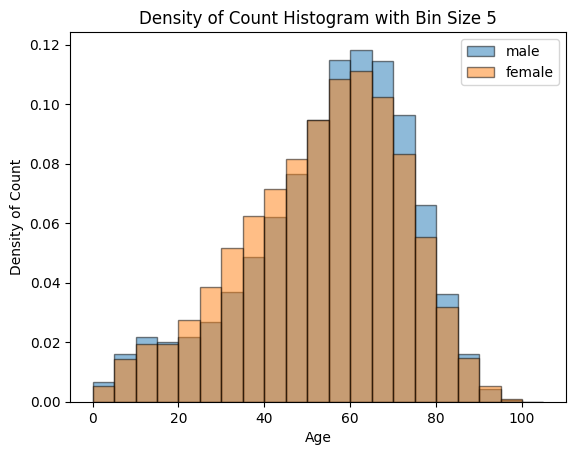

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
bins = list(range(0, 110, 5))
def generate_histogram(df, bin_size=5, show_together = True, label = '', bins = bins):

    df['term'] = pd.to_numeric(df['term'])
    # Sort the DataFrame by 'term' column

    df = df.sort_values(by='term')

    # Define the bins
    #bins = df['term'].tolist() + [df['term'].iloc[-1] + bin_size]
    bins = bins
    # Calculate aggregated counts based on bin_size
    #bins = [i for i in range(int(min(df['term'])), int(max(df['term'])) + bin_size, bin_size)]
    aggregated_counts = df.groupby(pd.cut(df['term'], bins=bins)).sum()/(df['count'].sum())

    # Extract the midpoints of the intervals for plotting
    midpoints = [(bin.left + bin.right) / 2 for bin in aggregated_counts.index]

    # Plot the histogram
    plt.bar(midpoints, aggregated_counts['count'], width=bin_size, edgecolor='k', label = label, alpha = 0.5)
    plt.xlabel('Age')
    plt.ylabel('Density of Count')
    plt.title(f'Density of Count Histogram with Bin Size {bin_size}')
    if(show_together):
      plt.show()


generate_histogram(df_male, label = 'male', show_together=False)
generate_histogram(df_female, label = 'female',  show_together=False)
plt.legend()

In [12]:
import re
df_male_adv_Y = pd.DataFrame(
    call_api({ "count":'patient.patient_age.exact', "search":'patient.patient_sex:Male AND adverse_event_flag:Y'}))

df_male_adv_N = pd.DataFrame(
    call_api({ "count":'patient.patient_age.exact', "search":'patient.patient_sex:Male AND adverse_event_flag:N'}))


df_male_adv_Y = df_male_adv_Y[df_male_adv_Y['term'].str.contains('YR')]
df_male_adv_N = df_male_adv_N[df_male_adv_N['term'].str.contains('YR')]

df_male_adv_Y['term'] = [x[:2] for x in df_male_adv_Y['term'].values if 'YR' in x]
df_male_adv_N['term'] = [x[:2] for x in df_male_adv_N['term'].values if 'YR' in x]
df_male_adv_Y['term'] = df_male_adv_Y['term'].str.replace(r'\bYR\b', '', regex=True)
df_male_adv_N['term'] = df_male_adv_N['term'].str.replace(r'\bYR\b', '', regex=True)

<ipython-input-12-1d141334073d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male_adv_Y['term'] = [x[:2] for x in df_male_adv_Y['term'].values if 'YR' in x]
<ipython-input-12-1d141334073d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male_adv_Y['term'] = df_male_adv_Y['term'].str.replace(r'\bYR\b', '', regex=True)


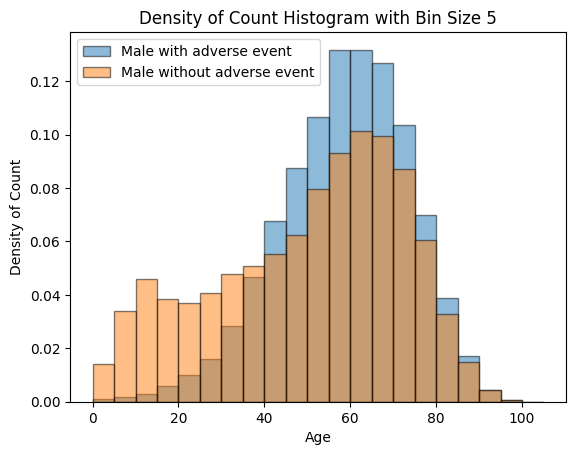

In [13]:
generate_histogram(df_male_adv_Y, show_together = False, label = 'Male with adverse event')
generate_histogram(df_male_adv_N, show_together = False, label = 'Male without adverse event')
plt.legend()

In [14]:
import re

# For female_adv_Y
df_female_adv_Y = pd.DataFrame(
    call_api({"count": 'patient.patient_age.exact', "search": 'patient.patient_sex:Female AND adverse_event_flag:Y'}))

# For female_adv_N
df_female_adv_N = pd.DataFrame(
    call_api({"count": 'patient.patient_age.exact', "search": 'patient.patient_sex:Female AND adverse_event_flag:N'}))

df_female_adv_Y = df_female_adv_Y[df_female_adv_Y['term'].str.contains('YR')]
df_female_adv_N = df_female_adv_N[df_female_adv_N['term'].str.contains('YR')]

df_female_adv_Y['term'] = [x[:2] for x in df_female_adv_Y['term'].values if 'YR' in x]
df_female_adv_N['term'] = [x[:2] for x in df_female_adv_N['term'].values if 'YR' in x]
df_female_adv_Y['term'] = df_female_adv_Y['term'].str.replace(r'\bYR\b', '', regex=True)
df_female_adv_N['term'] = df_female_adv_N['term'].str.replace(r'\bYR\b', '', regex=True)




<ipython-input-14-715170a51513>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female_adv_Y['term'] = [x[:2] for x in df_female_adv_Y['term'].values if 'YR' in x]
<ipython-input-14-715170a51513>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female_adv_Y['term'] = df_female_adv_Y['term'].str.replace(r'\bYR\b', '', regex=True)


<ipython-input-11-96d7a6b45870>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['term'] = pd.to_numeric(df['term'])


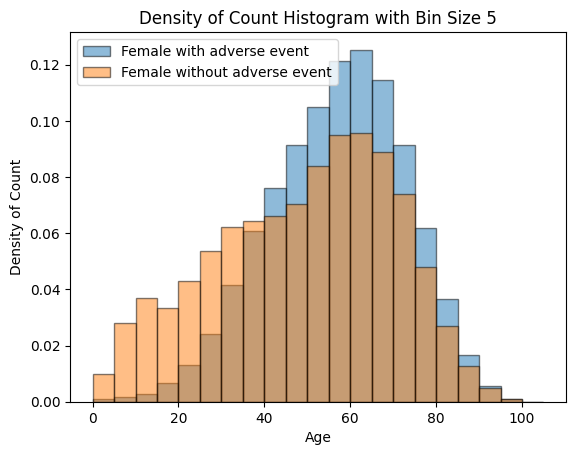

In [15]:
generate_histogram(df_female_adv_Y, show_together = False, label = 'Female with adverse event')
generate_histogram(df_female_adv_N, show_together = False, label = 'Female without adverse event')
plt.legend()

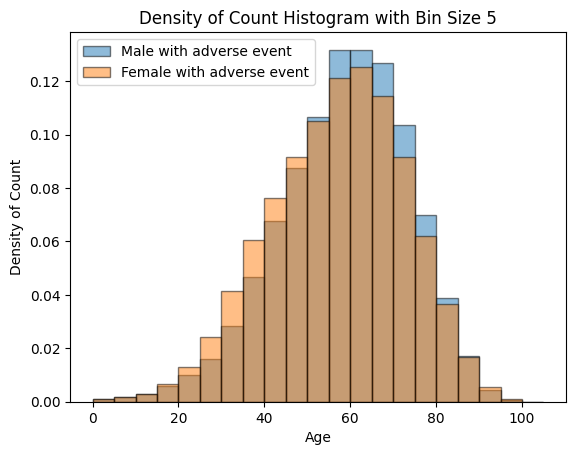

In [16]:
generate_histogram(df_male_adv_Y, show_together = False, label = 'Male with adverse event')
generate_histogram(df_female_adv_Y, show_together = False, label = 'Female with adverse event')
plt.legend()

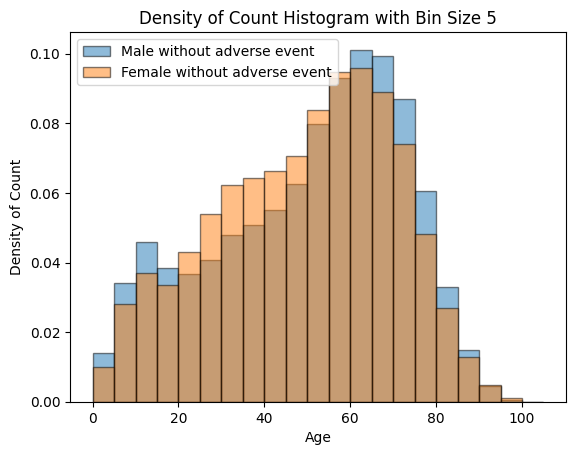

In [17]:
generate_histogram(df_male_adv_N, show_together = False, label = 'Male without adverse event')
generate_histogram(df_female_adv_N, show_together = False, label = 'Female without adverse event')
plt.legend()

In [22]:
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

df_device_Y = pd.DataFrame(
    call_api({"count": 'device.openfda.device_name.exact', "search": 'adverse_event_flag:Y'}))

df_device_N = pd.DataFrame(
    call_api({"count": 'device.openfda.device_name.exact', "search": 'adverse_event_flag:N'}))


words = df_device_Y['term'].apply(lambda x: word_tokenize(x))
words = words.sum()
word_counts = Counter(words)
word_count_dict = dict(word_counts)
del word_count_dict[',']
word_count_dict_sorted = dict(sorted(word_count_dict.items(), key=lambda item: item[1], reverse = True))
word_count_dict_sorted


stop_words = set(stopwords.words('english'))

filtered_word_count_dict_sorted = {}
for key in word_count_dict_sorted.keys():
    # Check if the key contains alphabets using a regular expression
    if re.search(r'[a-zA-Z]', key) and key.lower() not in stop_words:
        filtered_word_count_dict_sorted[key] = word_count_dict_sorted[key]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


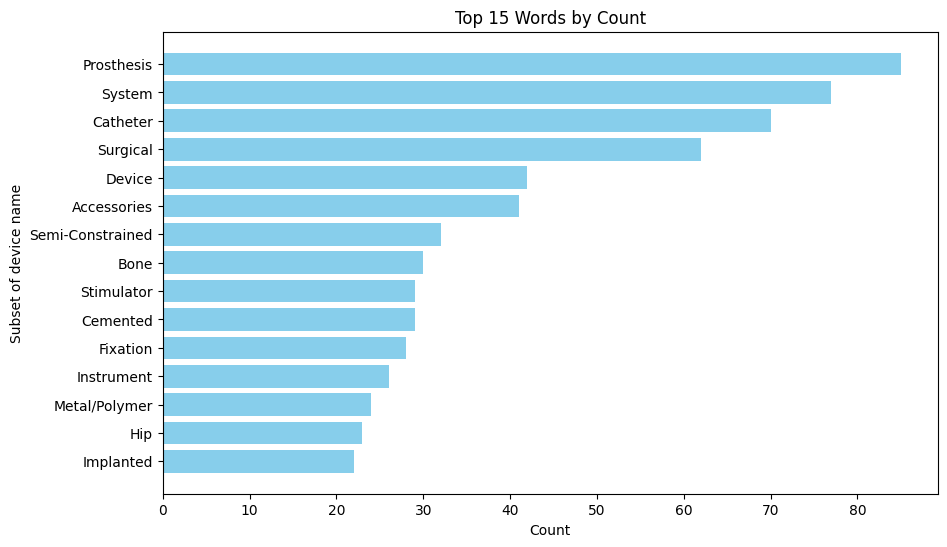

In [23]:
top_words = list(filtered_word_count_dict_sorted.keys())[:15]
top_counts = [filtered_word_count_dict_sorted[word] for word in top_words]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Subset of device name')
plt.title('Top 15 Words by Count')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent word at the top
plt.show()

In [24]:
df_device_operator_Y = pd.DataFrame(
    call_api({"count": 'device.device_operator.exact', "search": 'adverse_event_flag:Y'}))

df_device_operator_N = pd.DataFrame(
    call_api({"count": 'device.device_operator.exact', "search": 'adverse_event_flag:N'}))

In [25]:
df_device_operator_Y#['term'] #.unique_values()

,term,count
0,HEALTH PROFESSIONAL,4479318
1,LAY USER/PATIENT,1434857
2,PHYSICIAN,143015
3,,94630
4,0,89101
5,I,69507
6,OTHER HEALTH CARE PROFESSIONAL,33747
7,OTHER,29092
8,DENTIST,18787
9,UNKNOWN,18132


In [26]:
df_device_operator_N

,term,count
0,LAY USER/PATIENT,4904297
1,HEALTH PROFESSIONAL,3665410
2,OTHER,1179811
3,0,428891
4,,377886
5,I,234303
6,PHYSICIAN,70334
7,UNKNOWN,56742
8,INVALID DATA,38654
9,SERVICE AND TESTING PERSONNEL,20891


In [27]:
merged_df = df_device_operator_Y.merge(df_device_operator_N, on='term', suffixes=('_Y', '_N'), how='outer')


In [28]:
merged_df['count_ratio'] = merged_df['count_Y'] / merged_df['count_N']

# Display the merged dataframe with the ratio
merged_df = merged_df.sort_values(by='count_ratio', ascending=False)
merged_df

,term,count_Y,count_N,count_ratio
33,1,63.0,6.0,10.500000
35,ATTORNEY,61.0,6.0,10.166667
8,DENTIST,18787.0,3589.0,5.234606
45,PERSONAL CARE ASSISTANT,5.0,1.0,5.000000
38,RISK MANAGER,34.0,7.0,4.857143
16,PHLEBOTOMIST,374.0,104.0,3.596154
26,PHYSICAL THERAPIST,79.0,28.0,2.821429
2,PHYSICIAN,143015.0,70334.0,2.033369
11,NOT APPLICABLE,4334.0,2171.0,1.996315
6,OTHER HEALTH CARE PROFESSIONAL,33747.0,17902.0,1.885097


In [29]:
df_patient_prob_Y = pd.DataFrame(
    call_api({"count": 'patient.patient_problems.exact', "search": 'adverse_event_flag:Y'}))

df_patient_prob_N = pd.DataFrame(
    call_api({"count": 'patient.patient_problems.exact', "search": 'adverse_event_flag:N'}))

In [30]:
words = df_patient_prob_Y['term'].apply(lambda x: word_tokenize(x))
words = words.sum()
word_counts = Counter(words)
word_count_dict = dict(word_counts)
del word_count_dict[',']
word_count_dict_sorted = dict(sorted(word_count_dict.items(), key=lambda item: item[1], reverse = True))
word_count_dict_sorted


stop_words = set(stopwords.words('english'))

filtered_word_count_dict_sorted = {}
for key in word_count_dict_sorted.keys():
    # Check if the key contains alphabets using a regular expression
    if re.search(r'[a-zA-Z]', key) and key.lower() not in stop_words:
        filtered_word_count_dict_sorted[key] = word_count_dict_sorted[key]

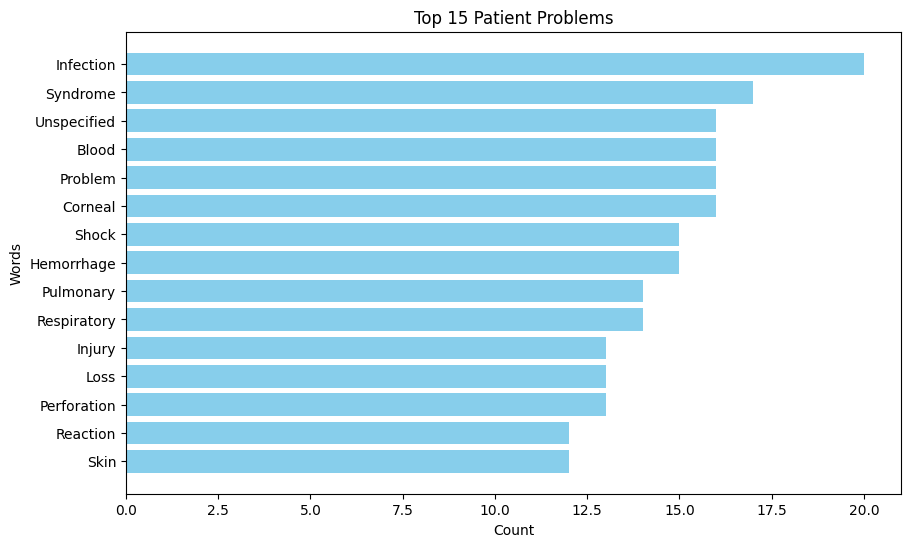

In [31]:
top_words = list(filtered_word_count_dict_sorted.keys())[:15]
top_counts = [filtered_word_count_dict_sorted[word] for word in top_words]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 15 Patient Problems')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent word at the top
plt.show()

In [32]:
df_age = pd.DataFrame(
    call_api({ "count":'patient.patient_age.exact', "search":'adverse_event_flag:Y'}))

In [33]:
df_age

,term,count
0,,2844940
1,65 YR,89395
2,60 YR,85255
3,62 YR,80564
4,67 YR,79110
...,...,...
995,004 YR,4
996,06 MO,4
997,08 YR,4
998,090 YR,4


In [34]:
df_age = df_age[df_age['term'].str.contains('YR')]

df_age['term'] = df_age['term'].str.extract('(\d+)')
df_age['term'] = df_age['term'].str.replace(r'\bYR\b', '', regex=True)
df_age['term'] = pd.to_numeric(df_age['term'])

<ipython-input-34-66d66b759f91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['term'] = df_age['term'].str.extract('(\d+)')
<ipython-input-34-66d66b759f91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['term'] = df_age['term'].str.replace(r'\bYR\b', '', regex=True)
<ipython-input-34-66d66b759f91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [35]:
df_age['term'].values

array([ 65.,  60.,  62.,  67.,  70.,  63.,  68.,  66.,  58.,  64.,  56.,
        61.,  59.,  55.,  69.,  72.,  57.,  71.,  73.,  54.,  74.,  50.,
        75.,  52.,  53.,  76.,  51.,  45.,  48.,  49.,  77.,  78.,  47.,
        79.,  80.,  46.,  43.,  42.,  81.,  44.,  40.,  82.,  41.,  39.,
        83.,  38.,  84.,  37.,  36.,  35.,  85.,  nan,  34.,  86.,  33.,
        32.,  30.,  87.,  31.,  29.,  88.,  28.,  27.,  89.,  25.,  26.,
        90.,  24.,  23.,  22.,  21.,  20.,  91.,  19.,  18.,  17.,  92.,
        16.,  14.,  15.,  13.,  12.,  11.,  93.,  10.,  72.,  71.,  75.,
        73.,   9.,  67.,  70.,  66.,  69.,   8.,  74.,  68.,  94.,  76.,
        65.,  77.,   7.,   6.,  78.,  62.,   0.,  64.,   5.,  79.,  63.,
        60.,  61.,  80.,  58.,   4.,  57.,  59.,  56.,  55.,  81.,  54.,
        82.,  nan,  95.,  83.,  53.,   3.,  84.,  51.,  50.,  52.,  85.,
        49.,  48.,  86.,   2.,  96.,  47.,  87.,  46.,  45.,  44.,  88.,
        43.,  nan,  42.,  89.,  41.,  97.,  nan,  4

<Axes: >

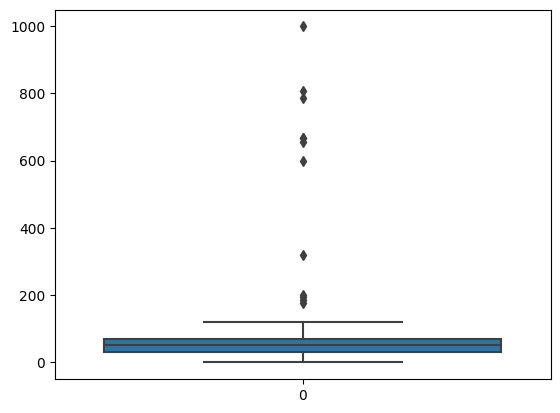

In [36]:
import seaborn as sns
sns.boxplot(df_age['term'].values)

In [37]:
!pip install matplotlib statsmodels

In [ ]:
df_patient_prob_Y = pd.DataFrame(
    call_api({"count": 'event_type.exact', "search": 'adverse_event_flag:Y'}))

df_patient_prob_N = pd.DataFrame(
    call_api({"count": 'patient.patient_problems.exact', "search": 'adverse_event_flag:N'}))

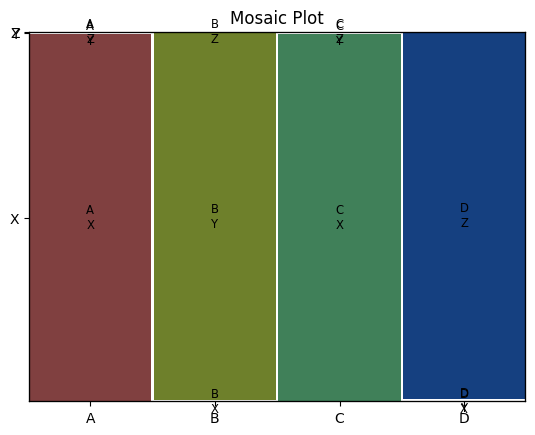

In [38]:
from statsmodels.graphics.mosaicplot import mosaic

data = {
    'Category': ['A', 'B', 'C', 'D'],
    'Subcategory': ['X', 'Y', 'X', 'Z'],
    'Count': [10, 15, 5, 20]
}
df = pd.DataFrame(data)

# Create a mosaic plot
mosaic(df, ['Category', 'Subcategory'], title='Mosaic Plot')
plt.show()